In [54]:
import sys
sys.path.append('.')
%load_ext autoreload
%autoreload 2
from IPython.display import Code, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
display(Code(filename='src/Q_learn_run.py'))


from src.solution_search import decide

'Train_agent - trains q-learn agent on specific board. Returns trained agent'


class Board(object):
    def __init__(self, board):
        self.prime_board = list.copy(board)
        self.episode_board = list.copy(board)
        self.piles_num = len(board)
        self.episode_counter = 0


    def check_win(self):
        res = False
        if sum(self.episode_board) == 0:
            res = False
        elif sum(self.episode_board) == 1:
            res = True
        return res

    def is_end(self):
        res = False
        if sum(self.episode_board) <= 1:
            res = True
        return res

    def make_move(self,move):
        self.update(move[1],move[0])
        reward = 0
        win = self.check_win()
        if win:
            reward = 1
        return win, reward

    def update(self, piles, num):
        self.episode_board[piles] -= num

    def computerUpdate(self):
        self.episode_board = decide(self.episode_board, -float('inf'), float('inf'), True)[1][1]
        return self.check_win()

    # codes states as string
    def actual_state(self):
        return self.episode_board, str(self.episode_board)  # example '[1 , 2]'

    def next_possible_states(self):
        res = []
        for piles in range(self.piles_num):
            for move in range(1, self.episode_board[piles] + 1):
                temp = list(self.episode_board[:])
                temp[piles] -= move
                res.append(temp)
        return res

    def next_possible_moves(self, state ):
        res = []
        piles_count = len(state)
        for piles in range(piles_count):
            #print("piles test")
            for move in range(1, min(3, state[piles]) + 1):
             #   print("moves test")
                temp = list(state[:])
                temp[piles] -= move
                res.append([move,piles])
        return res

    def start_game(self):
        self.episode_board=list.copy(self.prime_board)
        self.episode_counter+=1
        ##print("Episode ", self.episode_board)

    def end_game(self):
        #print("Episode ",self.episode_board," ended")
        pass
    def enemy_move(self):
        return self.computerUpdate()

In [56]:
display(Code(filename='src/nim_q_learn.py'))

import numpy as np
import random
import ast
from tqdm.notebook import trange
from src.Q_learn_run import Board

class Q_learning_player:
    def __init__(self, Board):
        self.board = Board

        # learning params
        self.learning_rate = 0.7
        self.discount_rate = 0.99
        # exploration params
        self.min_exploration_rate = 0.01
        self.max_exploration_rate = 1
        self.exploration_rate = self.max_exploration_rate
        self.exploration_decay = 0.001
        self.episodes_tought = 0
        # For metrics and plots
        self.history = {
            "rewards": [],
            "cum_rewards": [],# updatable array of reward history per episode
            "exploration_decay":[]
        }
        #Q table - On the begining of the NIM game all posibilites
        self.Q_table =  dict()
        possible_states = self.board.next_possible_states()
        possible_states.append(self.board.actual_state()[0])
        for state in possible_states: #for each starting state make Q value = 0
            moves = self.board.next_possible_moves(state)
            self.Q_table[str(state)] = {str(move): 0 for move in moves}
        print("Q table:",self.Q_table)
        #print("Q learning player initialized. use .train(num,steps)")

    def train(self, num_episodes, max_steps):
        cum_reward = 0
        # train loop
        for episode in trange(num_episodes):
            self.episodes_tought += 1
            is_done = False
            reward_gain = 0
            enemy_won = False
            self.board.start_game()
            for step in range(max_steps):

                actual_state, actual_state_key = self.board.actual_state()
                moves = self.board.next_possible_moves(actual_state)
                check_action_type = random.uniform(0, 1)
                if check_action_type > self.exploration_rate:
                    actions_for_state = self.Q_table[actual_state_key]
                    action_key = max(actions_for_state) # get best action you know for this state
                    action =  ast.literal_eval(action_key)
                else:
                    if len(moves) <=0:
                        break;
                    action = random.choice(moves) # get random action for that state

                # GET REWARD STATE ECT FROM GAME
                # self.upadte_Q_table(self.state,new_state,action,reward)
                #
                is_won, reward = self.board.make_move(action)
                reward += -1 / max_steps
                is_end = self.board.is_end()
                new_State, new_State_key = self.board.actual_state()
                if is_end == False:
                    enemy_won = self.board.enemy_move()
                if enemy_won:
                    reward = -3
                is_end = self.board.is_end()
                if is_end == True:
                    is_won = self.board.check_win() #check if enemy lose
                    if is_won:
                        reward = 1

                self.update_keys_Q_table() # add new states and moves to Q-table
                self.update_Q_table(actual_state_key,str(action),reward,new_State,new_State_key)
                reward_gain += reward
                if is_end == True:  # break episode loop is game is finished
                    break;

            #loop end

            # EPISODE IS FINISHED
            self.update_exploration_rate(self.episodes_tought)
            self.history['rewards'].append(reward_gain)
            cum_reward+=reward_gain
            self.history['cum_rewards'].append(cum_reward)
            self.board.end_game()
        return self.history

    def update_Q_table(self, state, action, reward,new_State,new_State_key):

        #count Q value
        #print(state)
        max_value = max(self.Q_table[new_State_key].values())
        q_table_value = self.Q_table[state][action]
        new_Q_value = q_table_value * (1 - self.learning_rate) + \
                            

Q table: {'[9, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[8, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[7, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[6, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[5, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[4, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[3, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[2, 10]': {'[1, 0]': 0, '[2, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[1, 10]': {'[1, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[0, 10]': {'[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[10, 9]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2, 1]': 0, '[3, 1]': 0}, '[10, 8]': {'[1, 0]': 0, '[2, 0]': 0, '[3, 0]': 0, '[1, 1]': 0, '[2

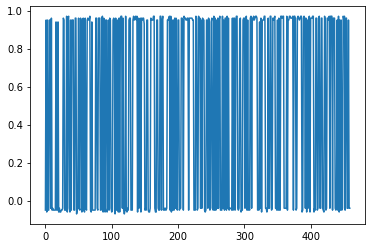

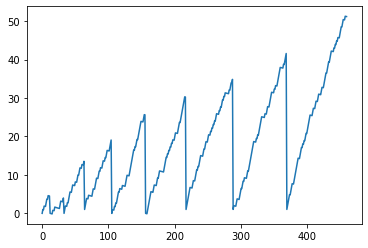

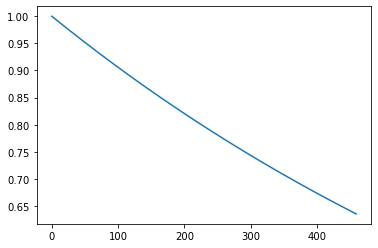

In [63]:
import src.Q_learn_run as board
import matplotlib.pyplot as plt

from src.nim_q_learn import Q_learning_player
env = board.Board([10, 10])
Q_learing = Q_learning_player(env)
for i in range(1,100,10):
      Q_learing.train(i, 100)
plt.plot(Q_learing.history['rewards'])
plt.show()
plt.plot(Q_learing.history['cum_rewards'])
plt.show()
plt.plot(Q_learing.history['exploration_decay'])
plt.show()

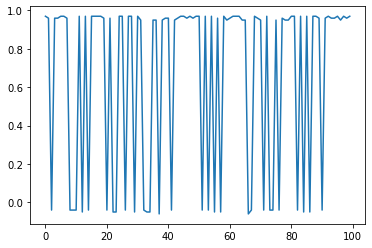

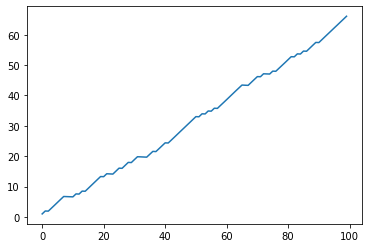

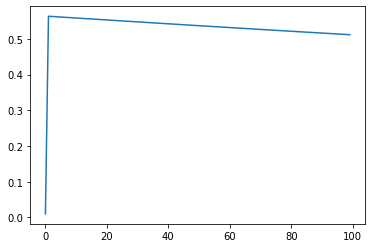

In [68]:
Q_learing.exploration_rate = Q_learing.min_exploration_rate
Q_learing.history['rewards'] = []
Q_learing.history['cum_rewards'] = []
Q_learing.history['exploration_decay'] = []
history = Q_learing.train(100, 100)

    
plt.plot(Q_learing.history['rewards'])
plt.show()
plt.plot(Q_learing.history['cum_rewards'])
plt.show()
plt.plot(Q_learing.history['exploration_decay'])
plt.show()

In [ ]:
table = Q_learing.Q_table
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         if(value!=0):
             print('Reward HERE\t' * (indent+1) + str(value))


In [ ]:
pretty(table)